In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
import operator
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
ranking = pd.read_csv("fifa_ranking.csv")

In [4]:
ranking = ranking.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

In [5]:
ranking.head()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted
0,1,Germany,GER,0.0,1993-08-08,0.0,0.0
1,2,Italy,ITA,0.0,1993-08-08,0.0,0.0
2,3,Switzerland,SUI,0.0,1993-08-08,0.0,0.0
3,4,Sweden,SWE,0.0,1993-08-08,0.0,0.0
4,5,Argentina,ARG,0.0,1993-08-08,0.0,0.0


In [6]:
ranking = ranking.replace({"IR Iran": "Iran"})
ranking['rank_date'] = pd.to_datetime(ranking['rank_date'])
ranking['weighted_points'] =  ranking['cur_year_avg_weighted'] + ranking['two_year_ago_weighted'] + ranking['three_year_ago_weighted']

In [7]:
ranking.tail()

,rank,country_full,country_abrv,cur_year_avg_weighted,rank_date,two_year_ago_weighted,three_year_ago_weighted,weighted_points
57788,206,Anguilla,AIA,0.0,2018-06-07,0.0,0.0,0.0
57789,206,Bahamas,BAH,0.0,2018-06-07,0.0,0.0,0.0
57790,206,Eritrea,ERI,0.0,2018-06-07,0.0,0.0,0.0
57791,206,Somalia,SOM,0.0,2018-06-07,0.0,0.0,0.0
57792,206,Tonga,TGA,0.0,2018-06-07,0.0,0.0,0.0


In [8]:
result = pd.read_csv("results.csv")
result =  result.replace({'Germany DR': 'Germany', 'China': 'China PR'})
result['date'] = pd.to_datetime(result['date'])

In [9]:
result.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [36]:
world_cup22 = pd.read_csv('Qatar2022-teams.csv', sep=';')

In [37]:
world_cup22.head()

,Team,Group
0,Senegal,A
1,Qatar,A
2,Netherlands,A
3,Ecuador,A
4,Iran,B


In [38]:
result = result[result['tournament'] != 'Friendly']

In [39]:
result.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
29,1884-01-26,Northern Ireland,Scotland,0,5,British Championship,Belfast,Ireland,False,1884
30,1884-02-09,Wales,Northern Ireland,6,0,British Championship,Wrexham,Wales,False,1884
31,1884-02-23,Northern Ireland,England,1,8,British Championship,Belfast,Ireland,False,1884
32,1884-03-15,Scotland,England,1,0,British Championship,Glasgow,Scotland,False,1884
33,1884-03-17,Wales,England,0,4,British Championship,Wrexham,Wales,False,1884


In [40]:
import datetime

ranking['year'] = ranking['rank_date'].dt.year
result['year'] = result['date'].dt.year

ranking_sub = ranking[ranking['rank_date'] > '2011-08-24']
result_sub = result[result['date'] > '2011-08-24']

In [41]:
ranking_sub = ranking_sub[['rank', 'country_full', 'weighted_points', 'year']]
ranking_sub = ranking_sub.groupby(['year', 'country_full'], as_index=False).agg({'rank': 'mean', 'weighted_points': 'mean'})

result_sub.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year
43746,2022-06-14,Turkey,Lithuania,2,0,UEFA Nations League,İzmir,Turkey,False,2022
43747,2022-06-14,Moldova,Andorra,2,1,UEFA Nations League,Chișinău,Moldova,False,2022
43748,2022-06-14,Liechtenstein,Latvia,0,2,UEFA Nations League,Vaduz,Liechtenstein,False,2022
43749,2022-06-14,Chile,Ghana,0,0,Kirin Cup,Suita,Japan,True,2022
43750,2022-06-14,Japan,Tunisia,0,3,Kirin Cup,Suita,Japan,False,2022


In [42]:
result_all = result_sub.merge(ranking_sub, left_on=['home_team', 'year'], right_on=['country_full', 'year'], how='inner')
result_all = result_all.merge(ranking_sub, left_on=['away_team', 'year'], right_on=['country_full', 'year'], how='inner')
result_all.drop(['date', 'tournament', 'city', 'country', 'year', 'country_full_x', 'country_full_y'], axis=1, inplace=True)
result_all.head()

,home_team,away_team,home_score,away_score,neutral,rank_x,weighted_points_x,rank_y,weighted_points_y
0,Fiji,Tahiti,3,0,True,153.75,145.7750,183.0,64.9125
1,New Caledonia,Tahiti,3,1,False,160.00,118.6800,183.0,64.9125
2,New Caledonia,Vanuatu,5,0,False,160.00,118.6800,173.0,92.0500
3,American Samoa,Vanuatu,0,8,True,199.00,15.1775,173.0,92.0500
4,Guam,Vanuatu,1,4,True,188.50,35.8500,173.0,92.0500


In [43]:
result_all['weighted_diff'] = result_all['weighted_points_x'] - result_all['weighted_points_y']
result_all['rank_diff'] = result_all['rank_x'] - result_all['rank_y']
result_all['neutral'] = result_all['neutral'].astype(int)
result_all['is_win'] = (result_all['home_score'] - result_all['away_score']).apply(lambda x: 1 if x>0 else 0)
train = result_all.drop(['home_team', 'away_team', 'home_score', 'away_score'], axis=1)
train.head()

,neutral,rank_x,weighted_points_x,rank_y,weighted_points_y,weighted_diff,rank_diff,is_win
0,1,153.75,145.7750,183.0,64.9125,80.8625,-29.25,1
1,0,160.00,118.6800,183.0,64.9125,53.7675,-23.00,1
2,0,160.00,118.6800,173.0,92.0500,26.6300,-13.00,1
3,1,199.00,15.1775,173.0,92.0500,-76.8725,26.00,0
4,1,188.50,35.8500,173.0,92.0500,-56.2000,15.50,0


In [44]:
train_X = train.drop('is_win', axis=1)
train_y = train['is_win']

In [20]:
classifiers = {'Random Forest': RandomForestClassifier(n_estimators=300),
              #'LightGBM': LGBMClassifier(n_estimators=300, learning_rate=.01),
              'Logistic Regression': LogisticRegression(C=1e-5)}

Running Random Forest
Running Logistic Regression


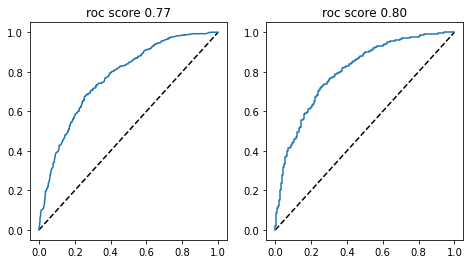

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3)

fig = plt.figure(figsize=[12, 4])
for i, (name, clf) in enumerate(classifiers.items()):
    print('Running', name)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    # plot
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.plot(fpr, tpr)
    ax.set_title('roc score {0:.2f}'.format(roc_auc_score(y_test, y_pred)))

In [23]:
rf = RandomForestClassifier(n_estimators=300)
rf = rf.fit(train_X, train_y)

lr = LogisticRegression(C=1e-5)
lr = lr.fit(train_X, train_y)

In [48]:
world_cup_rankings = world_cup22[['Team', 'Group']]
world_cup_rankings = world_cup_rankings.merge(ranking_sub[ranking_sub['year']==2018],left_on='Team', right_on='country_full')
world_cup_rankings.drop('country_full', axis=1, inplace=True)
world_cup_rankings = world_cup_rankings.set_index('Team')
world_cup_rankings.head()

,Group,year,rank,weighted_points
Team,,,,
Senegal,A,2018,26.833333,583.818333
Qatar,A,2018,101.166667,247.435000
Netherlands,A,2018,19.666667,797.201667
Ecuador,A,2018,64.500000,315.190000
Iran,B,2018,34.833333,520.541667


In [54]:
def pred_wining(dat, home, away):
    row = pd.DataFrame(columns=train_X.columns)
    row.loc[0, 'neutral'] = 1
    row['weighted_points_x'] = dat.loc[home, 'weighted_points']
    row['rank_x'] = dat.loc[home, 'rank']
    row['weighted_points_y'] = dat.loc[away, 'weighted_points']
    row['rank_y'] = dat.loc[away, 'rank']
    row['weighted_diff'] = row['weighted_points_x'] - row['weighted_points_y']
    row['rank_diff'] = row['rank_x'] - row['rank_y']
    
    y_pred = np.mean([lr.predict_proba(row)[:, 1][0], rf.predict_proba(row)[:, 1][0]])
    return y_pred

def main():
    # Group Stage
    world_cup_rankings['Points'] = 0
    for group in world_cup_rankings['Group'].unique():
        group_teams = list(world_cup_rankings.query('Group=="{}"'.format(group)).index)
        for home, away in combinations(group_teams, 2):
            # get wining probability
            y_pred = pred_wining(world_cup_rankings, home, away)
            # if y_pred in [0.4, 0.55] then draw
            if (y_pred > 0.4) & (y_pred < 0.55):
                world_cup_rankings.loc[home, 'Points'] += 1
                world_cup_rankings.loc[away, 'Points'] += 1
            else:
                # give a sense of randomness
                is_win = np.random.choice([1, 0], p=[y_pred, 1-y_pred])
                if is_win:
                    world_cup_rankings.loc[home, 'Points'] += 3
                else:
                    world_cup_rankings.loc[away, 'Points'] += 3
    # Eliminating Stage
    final_teams = world_cup_rankings.sort_values(by=['Group', 'Points'], ascending=False).reset_index()
    final_teams = final_teams.groupby('Group').apply(lambda x: x.iloc[[0, 1]]).reset_index(drop=True)
    final_teams.set_index('Team', inplace=True)
    final_teams = final_teams.iloc[pairing]
    
    for f in finals:
        winners = []
        rds = int(len(final_teams)/2)
        for i in range(rds):
            home = final_teams.index[2*i]
            away = final_teams.index[2*i+1]
            y_pred = pred_wining(world_cup_rankings, home, away)
            # give a sense of randomness
            is_win = np.random.choice([1, 0], p=[y_pred, 1-y_pred])
            if is_win:
                winners.append(home)
            else:
                winners.append(away)
        final_teams = final_teams.loc[winners]
    print('The Champion of 2022 World Cup is {}'.format(winners[0]))
    return winners[0]

In [55]:
num_simulations = 1000
pairing = [0, 3, 4, 7, 1, 2, 5, 6, 8, 11, 12, 15, 9, 10, 13, 14]
finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

In [56]:
if __name__ == '__main__':
    champions = []
    for sim in range(num_simulations):
        print('######## Simulation {} ########'.format(sim+1))
        champions.append(main())

######## Simulation 1 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 2 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 3 ########
The Champion of 2022 World Cup is Netherlands
######## Simulation 4 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 5 ########
The Champion of 2022 World Cup is Germany
######## Simulation 6 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 7 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 8 ########
The Champion of 2022 World Cup is Argentina
######## Simulation 9 ########
The Champion of 2022 World Cup is England
######## Simulation 10 ########
The Champion of 2022 World Cup is England
######## Simulation 11 ########
The Champion of 2022 World Cup is Spain
######## Simulation 12 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 13 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 14 ########
The Champi

The Champion of 2022 World Cup is Argentina
######## Simulation 112 ########
The Champion of 2022 World Cup is Germany
######## Simulation 113 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 114 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 115 ########
The Champion of 2022 World Cup is Germany
######## Simulation 116 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 117 ########
The Champion of 2022 World Cup is Germany
######## Simulation 118 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 119 ########
The Champion of 2022 World Cup is Uruguay
######## Simulation 120 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 121 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 122 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 123 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 124 ########
The Champion of 2022 Wo

The Champion of 2022 World Cup is France
######## Simulation 221 ########
The Champion of 2022 World Cup is Mexico
######## Simulation 222 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 223 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 224 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 225 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 226 ########
The Champion of 2022 World Cup is Uruguay
######## Simulation 227 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 228 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 229 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 230 ########
The Champion of 2022 World Cup is Germany
######## Simulation 231 ########
The Champion of 2022 World Cup is Argentina
######## Simulation 232 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 233 ########
The Champion of

The Champion of 2022 World Cup is Brazil
######## Simulation 330 ########
The Champion of 2022 World Cup is Germany
######## Simulation 331 ########
The Champion of 2022 World Cup is Spain
######## Simulation 332 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 333 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 334 ########
The Champion of 2022 World Cup is Mexico
######## Simulation 335 ########
The Champion of 2022 World Cup is Spain
######## Simulation 336 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 337 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 338 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 339 ########
The Champion of 2022 World Cup is Netherlands
######## Simulation 340 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 341 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 342 ########
The Champion of 2022 W

The Champion of 2022 World Cup is Germany
######## Simulation 440 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 441 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 442 ########
The Champion of 2022 World Cup is Germany
######## Simulation 443 ########
The Champion of 2022 World Cup is Germany
######## Simulation 444 ########
The Champion of 2022 World Cup is England
######## Simulation 445 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 446 ########
The Champion of 2022 World Cup is Germany
######## Simulation 447 ########
The Champion of 2022 World Cup is Uruguay
######## Simulation 448 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 449 ########
The Champion of 2022 World Cup is Germany
######## Simulation 450 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 451 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 452 ########
The Champion of 2022 Wor

The Champion of 2022 World Cup is Portugal
######## Simulation 550 ########
The Champion of 2022 World Cup is France
######## Simulation 551 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 552 ########
The Champion of 2022 World Cup is Germany
######## Simulation 553 ########
The Champion of 2022 World Cup is Argentina
######## Simulation 554 ########
The Champion of 2022 World Cup is France
######## Simulation 555 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 556 ########
The Champion of 2022 World Cup is Germany
######## Simulation 557 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 558 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 559 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 560 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 561 ########
The Champion of 2022 World Cup is France
######## Simulation 562 ########
The Champion of

The Champion of 2022 World Cup is Belgium
######## Simulation 659 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 660 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 661 ########
The Champion of 2022 World Cup is Spain
######## Simulation 662 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 663 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 664 ########
The Champion of 2022 World Cup is Poland
######## Simulation 665 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 666 ########
The Champion of 2022 World Cup is Germany
######## Simulation 667 ########
The Champion of 2022 World Cup is Spain
######## Simulation 668 ########
The Champion of 2022 World Cup is France
######## Simulation 669 ########
The Champion of 2022 World Cup is Serbia
######## Simulation 670 ########
The Champion of 2022 World Cup is France
######## Simulation 671 ########
The Champion of 2022 World Cup

The Champion of 2022 World Cup is Brazil
######## Simulation 769 ########
The Champion of 2022 World Cup is Germany
######## Simulation 770 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 771 ########
The Champion of 2022 World Cup is Spain
######## Simulation 772 ########
The Champion of 2022 World Cup is Poland
######## Simulation 773 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 774 ########
The Champion of 2022 World Cup is Germany
######## Simulation 775 ########
The Champion of 2022 World Cup is Spain
######## Simulation 776 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 777 ########
The Champion of 2022 World Cup is Spain
######## Simulation 778 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 779 ########
The Champion of 2022 World Cup is Germany
######## Simulation 780 ########
The Champion of 2022 World Cup is England
######## Simulation 781 ########
The Champion of 2022 World Cup 

The Champion of 2022 World Cup is Poland
######## Simulation 878 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 879 ########
The Champion of 2022 World Cup is Germany
######## Simulation 880 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 881 ########
The Champion of 2022 World Cup is Belgium
######## Simulation 882 ########
The Champion of 2022 World Cup is Spain
######## Simulation 883 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 884 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 885 ########
The Champion of 2022 World Cup is Poland
######## Simulation 886 ########
The Champion of 2022 World Cup is Spain
######## Simulation 887 ########
The Champion of 2022 World Cup is Poland
######## Simulation 888 ########
The Champion of 2022 World Cup is France
######## Simulation 889 ########
The Champion of 2022 World Cup is France
######## Simulation 890 ########
The Champion of 2022 World Cup 

The Champion of 2022 World Cup is Belgium
######## Simulation 988 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 989 ########
The Champion of 2022 World Cup is Germany
######## Simulation 990 ########
The Champion of 2022 World Cup is Spain
######## Simulation 991 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 992 ########
The Champion of 2022 World Cup is Netherlands
######## Simulation 993 ########
The Champion of 2022 World Cup is Germany
######## Simulation 994 ########
The Champion of 2022 World Cup is Spain
######## Simulation 995 ########
The Champion of 2022 World Cup is Brazil
######## Simulation 996 ########
The Champion of 2022 World Cup is Denmark
######## Simulation 997 ########
The Champion of 2022 World Cup is Portugal
######## Simulation 998 ########
The Champion of 2022 World Cup is Uruguay
######## Simulation 999 ########
The Champion of 2022 World Cup is Switzerland
######## Simulation 1000 ########
The Champion of 202

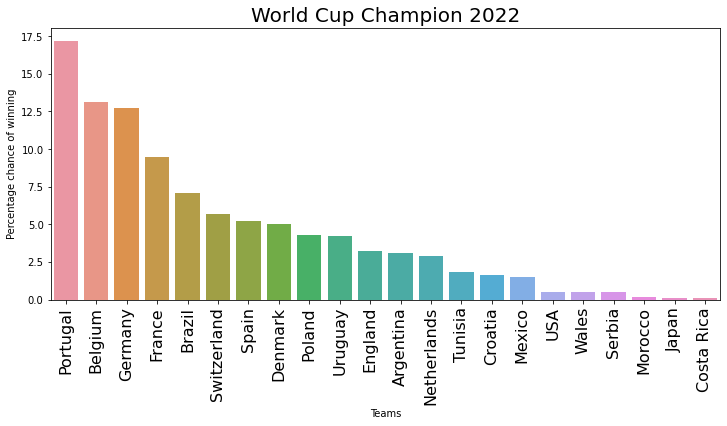

In [57]:
sorted_champ = Counter(champions).most_common()

fig, ax = plt.subplots(figsize=[12, 5])
plt.xticks(rotation=90, size=16)
ax.set_title('World Cup Champion 2022', size=20)
ax.set(xlabel='Teams', ylabel='Percentage chance of winning')
sns.barplot(x=[t[0] for t in sorted_champ], y=[t[1]/10 for t in sorted_champ], ax=ax);